In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional

In [2]:
df_2022 = pd.read_csv('../Tweet_Sentiment/2022_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()
df_2021 = pd.read_csv('../Tweet_Sentiment/2021_final.csv').drop(['fark', 'tweet_count'], axis= 1).set_index('Unnamed: 0').sort_index()

In [3]:
df = pd.concat([df_2022, df_2021]).sort_index()
df

,şimdi,açılış,avg_polar
Unnamed: 0,,,
2021-01-04,1495.43,1482.17,0.598575
2021-01-05,1489.56,1492.19,0.543668
2021-01-06,1505.42,1501.61,0.557471
2021-01-07,1522.24,1511.60,0.535849
2021-01-08,1540.61,1526.51,0.562334
...,...,...,...
2022-10-12,3517.75,3576.84,0.488859
2022-10-13,3553.43,3529.78,0.497640
2022-10-14,3626.96,3584.94,0.479313


In [4]:
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_for_training_scaled = scaler.transform(df)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df.loc[:,['şimdi']])

array([[5.94174618e-02],
       [5.70701941e-02],
       [6.34122154e-02],
       [7.01381169e-02],
       [7.74838250e-02],
       [7.57163765e-02],
       [8.10507122e-02],
       [8.49494958e-02],
       [7.98790777e-02],
       [7.10378362e-02],
       [8.39458089e-02],
       [8.72407809e-02],
       [8.89762394e-02],
       [8.18664577e-02],
       [7.82195955e-02],
       [7.73238750e-02],
       [7.56843865e-02],
       [4.80490087e-02],
       [6.05731012e-02],
       [5.06282040e-02],
       [5.82258335e-02],
       [6.58154656e-02],
       [7.46607059e-02],
       [7.52005374e-02],
       [7.21095018e-02],
       [7.52045362e-02],
       [7.88593959e-02],
       [8.00830141e-02],
       [7.94752037e-02],
       [7.66160958e-02],
       [8.62330953e-02],
       [7.83675493e-02],
       [7.74758275e-02],
       [7.98031014e-02],
       [8.53733635e-02],
       [8.14825774e-02],
       [6.83866634e-02],
       [5.44550100e-02],
       [5.65303625e-02],
       [4.98044610e-02],


In [5]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (399, 5, 3).
TrainY shape = (399, 1, 1).


In [6]:
X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.1, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.1, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((359, 5, 2), (359, 5, 3))

In [7]:
def build_model(input_shape):
    tf.random.set_seed(12345)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [8]:
cnn_lstm_model_without_twitter=build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter=build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=50, batch_size=64, verbose=1, )


history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=50, batch_size=64, verbose=1, )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           659456    
 l)                                                              
                                                        

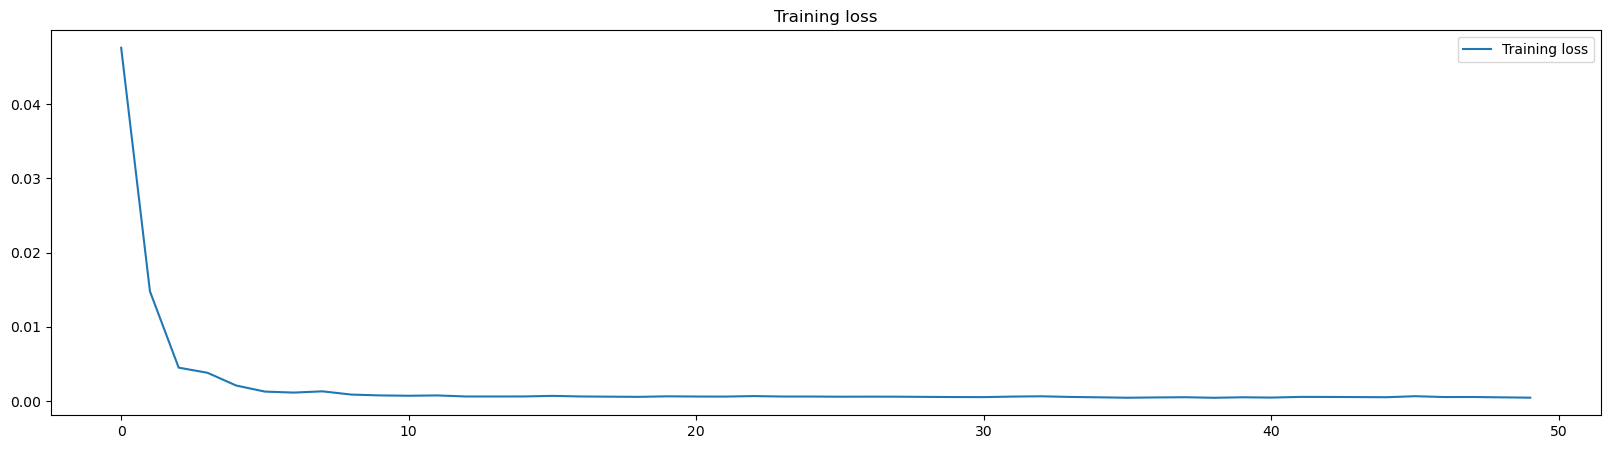

In [9]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.title('Training loss')
plt.legend()

In [10]:
training_dates= df.index[:X_train_lstm_without_twitter.shape[0]]
#Make prediction
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)

training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)

training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])

training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])

y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)

y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)

y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

12/12 [==============================] - 0s 5ms/step


In [11]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['şimdi']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [12]:
testing_dates= df.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

2/2 [==============================] - 0s 19ms/step


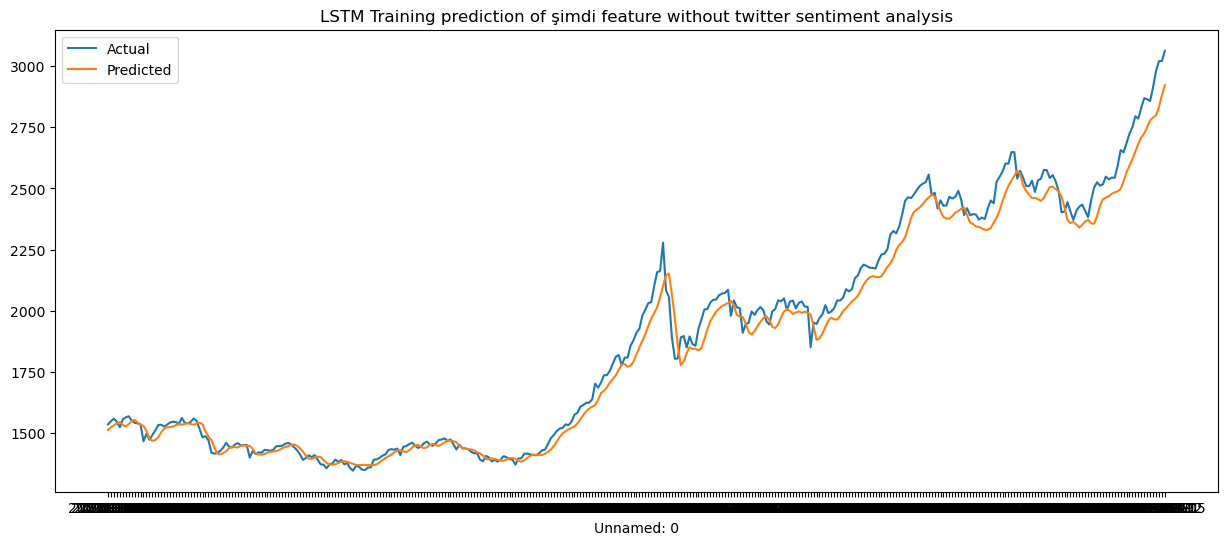

Mean square error for şimdi =3876.6278426157755
Total mean square error 3876.6278426157755


In [13]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm ,y_train_pred_lstm_without_twitter)

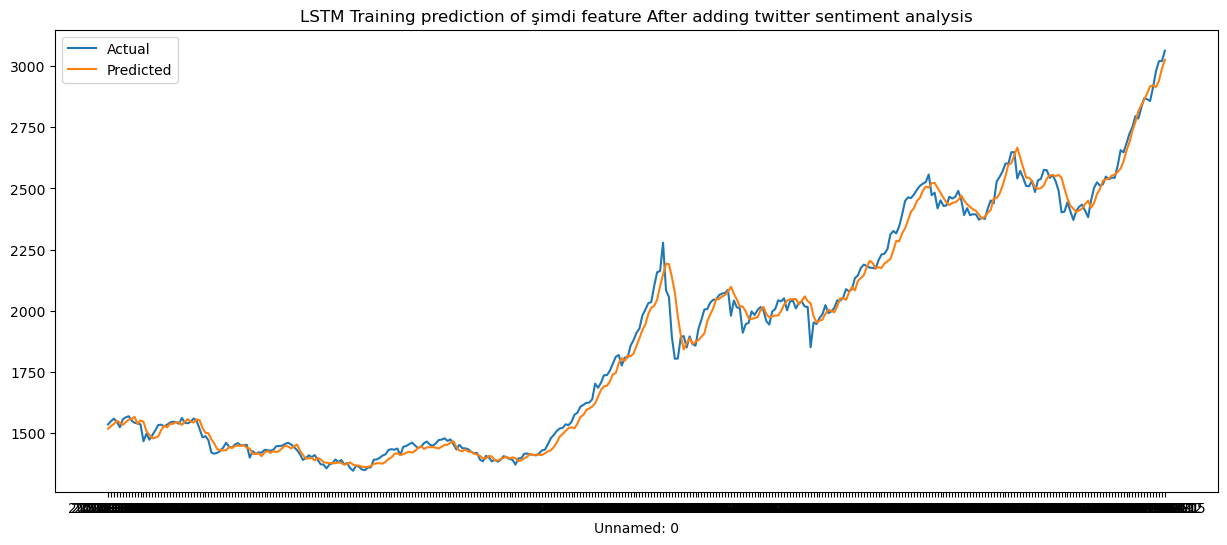

Mean square error for şimdi =1932.317867503392
Total mean square error 1932.317867503392


In [14]:
training_dates= df.index[:X_train_lstm_twitter.shape[0]]
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm ,y_train_pred_lstm_twitter)

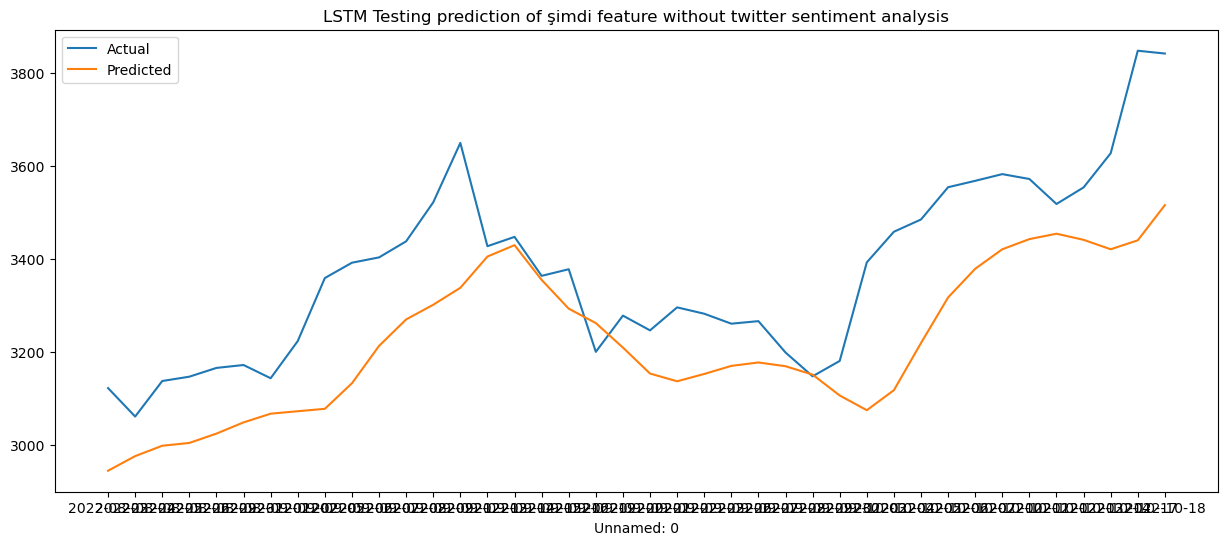

Mean square error for şimdi =33627.83260472162
Total mean square error 33627.83260472162


In [15]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

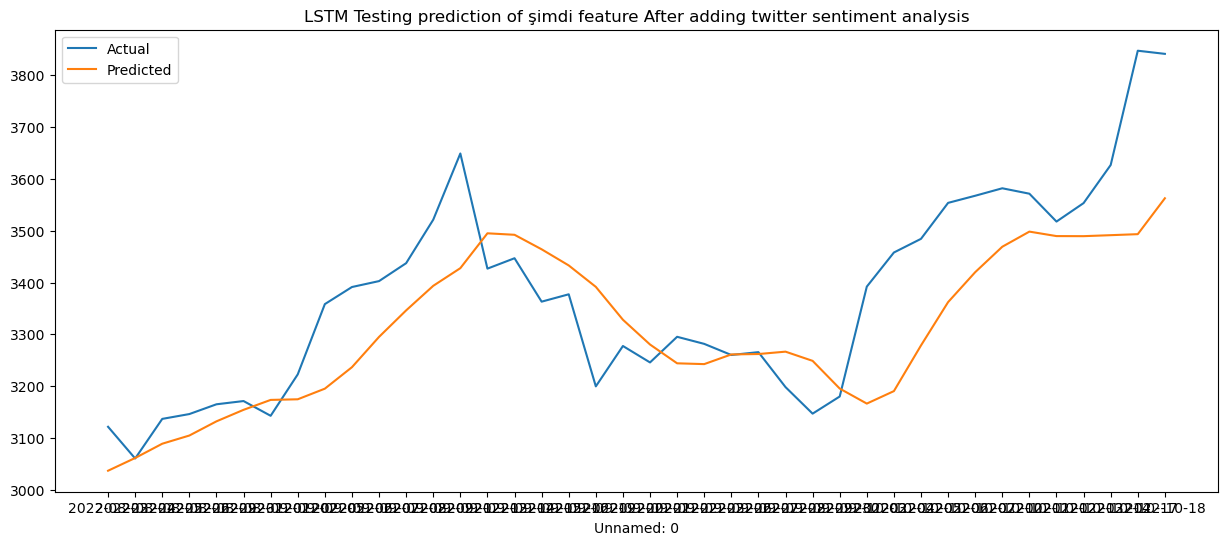

Mean square error for şimdi =17496.57887477966
Total mean square error 17496.57887477966


In [16]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

In [17]:
X_test_lstm_twitter

array([[[0.62638857, 0.60575946, 0.69866186],
        [0.65306025, 0.63236836, 0.71916518],
        [0.66905925, 0.65252807, 0.79259066],
        [0.66913523, 0.67098346, 0.78543184],
        [0.68604595, 0.66801892, 0.59582905]],

       [[0.65306025, 0.63236836, 0.71916518],
        [0.66905925, 0.65252807, 0.79259066],
        [0.66913523, 0.67098346, 0.78543184],
        [0.68604595, 0.66801892, 0.59582905],
        [0.70965059, 0.68897477, 0.59126714]],

       [[0.66905925, 0.65252807, 0.79259066],
        [0.66913523, 0.67098346, 0.78543184],
        [0.68604595, 0.66801892, 0.59582905],
        [0.70965059, 0.68897477, 0.59126714],
        [0.68517023, 0.71417541, 0.63198333]],

       [[0.66913523, 0.67098346, 0.78543184],
        [0.68604595, 0.66801892, 0.59582905],
        [0.70965059, 0.68897477, 0.59126714],
        [0.68517023, 0.71417541, 0.63198333],
        [0.71574869, 0.69133521, 0.76588353]],

       [[0.68604595, 0.66801892, 0.59582905],
        [0.70965059, 0.688

In [18]:
cnn_lstm_model_twitter.save('cnn_lstm_twitter.h5')

In [20]:
from pickle import dump
dump(scaler_for_inference, open('scaler.pkl', 'wb'))